# TP3: Noise to Noise

### Name: **Nicolás Violante**


The objective of this lesson is to study more in detail some of the top CNN image denoising algorithms. 

We will cover the following topics:
* The noise-to-noise training strategy
* Strangling networks

There are <font color='blue'>**4 questions**</font> in the notebook and corresponding text areas to fill-in the answers. 


#### Instructions
To solve this TP, answer the questions below. Then export the notebook with the answers using  the menu option **File->Download .ipynb**. Then **[submit your solution here](https://docs.google.com/forms/d/e/1FAIpQLScQZ6QQvsdihV5NqNBeVe35Cg1MnvjFFNum7o-v8Ody6dhpVA/viewform)** by 24/11/2021.  You will receive an acknowledgement of receipt.

In [1]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run' 
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output. Something similar 
# applies to the next two or three cells. They only define 
# functions that are used later.


# This notebook can also run on colab (https://colab.research.google.com/)
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr MVAdenoising
    !git clone --quiet https://github.com/gfacciol/MVAdenoising
    !cp -r MVAdenoising/* .

except ImportError:
    # %matplotlib notebook
    pass


# These are all the includes used through the notebook
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io # read and write images
import vistools        # image visualization toolbox


# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = None
else:
    loadmap = {'cuda:0': 'cpu'}
    

# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

persistent_storage = 'trainings/'

     |████████████████████████████████| 53 kB 802 kB/s 


**A note about Colab.** The current notebook runs on a virtual machine with sessions limited to 24h. After that all the content of the session (state and files) is removed. So  a persistent storage must be connected to the virtual machine in order to store the results.

The following code  connects a google drive account to the virtual machine.

In [2]:
# this cell connects the persistent storage

persistent_storage = 'trainings/'
try:
    # Load the Drive helper and mount
    from google.colab import drive
    import os

    # This will prompt for authorization.
    drive.mount(  'Drive')
    persistent_storage = 'Drive/My Drive/CNN_trainings/'
    os.makedirs(persistent_storage, exist_ok=True)
except:
    pass

Mounted at Drive


-----------------------------



# Reminder about losses

### Uniform salt and pepper noise

The salt and pepper noise contaminates a random set of pixels of an image. A corrupted pixel can take the value 0 or 255, chosen randomly (hence the name salt and pepper). 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Noise_salt_and_pepper.png"/>

In our uniform salt and pepper noise a pixel is corrupted with probability $p$. The corrupted pixels are replaced with a value drawn from a uniform distribution in $[0,255]$ (our images have floating point pixels, thus assume that any real number in the interval $[0,255]$ can be chosen). If we denote by $v(x)$ the corrupted pixel and $u(x)$ the clean pixel, the PDF of $v(x)$ given $u(x)$ is:

$$P(v(x)\,|\,u(x)) = (1-p)\delta_{u(x)} + p.$$


### Uniform salt-and-pepper noise denoisers trained with $L_1$ and $L_2$ losses

Let's compare the results of networks pretrained with this type of noise using $L_1$ and $L_2$ losses.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


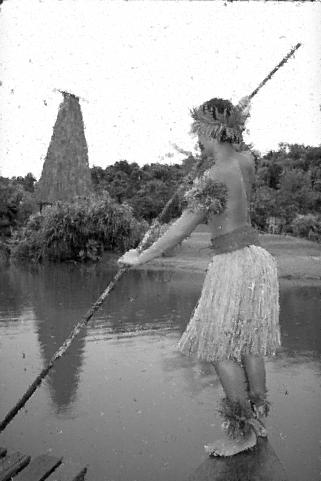
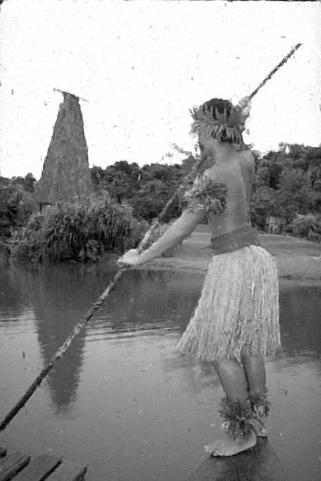
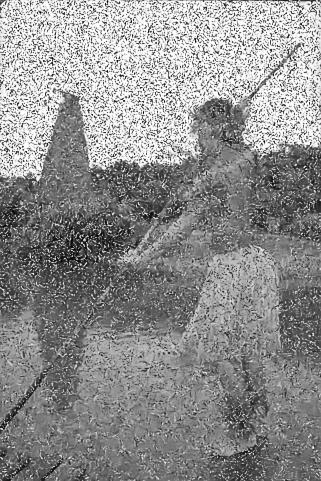
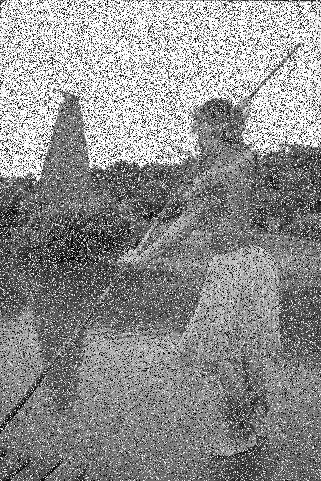
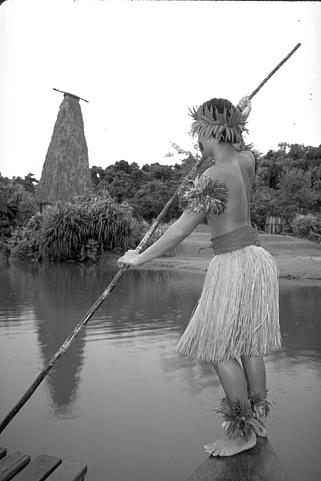

In [3]:
# denoise image with both models
from models import DnCNN
from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

p=0.4
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
mask = np.random.binomial(1, 1-p, im_clean.shape)
noise = np.random.uniform(0, 255., im_clean.shape)
im_noisy = im_clean * mask + noise * (1 - mask)

outputs = list()

net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn usp l1 loss - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn usp l2 loss - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l2_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'dncnn gaussian MSE loss - PSNR = %f' % PSNR(out, im_clean)))

outputs.append((im_noisy, 'noisy input with p = %f' % (p)))
outputs.append((im_clean, 'clean image'))

vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

Although there are some difference in performance between both losses, both results are of comparable quality. We will see a different training setup, in which the choice of the loss is crucial.

<!-- It seems that both losses performed decently for both types of considered noise. We will see a different training setup, in which the choice of the loss is crucial.-->

# Noise to noise training

We will now follow the training approach proposed in

*Noise2Noise: Learning Image Restoration without Clean Data*<br/>
J. Lehtinen, J. Munkberg, J. Hasselgren, S. Laine, T. Karras, M. Aittala, T. Aila. In ICML 2018.

The idea  here is to compute the loss between two noise realizations of the same clean image. To train with this approach, we pass the flag `noise2noise=True` to the data loader. The data loader will then return pairs of noisy images.



A minibatch of noisy patches:


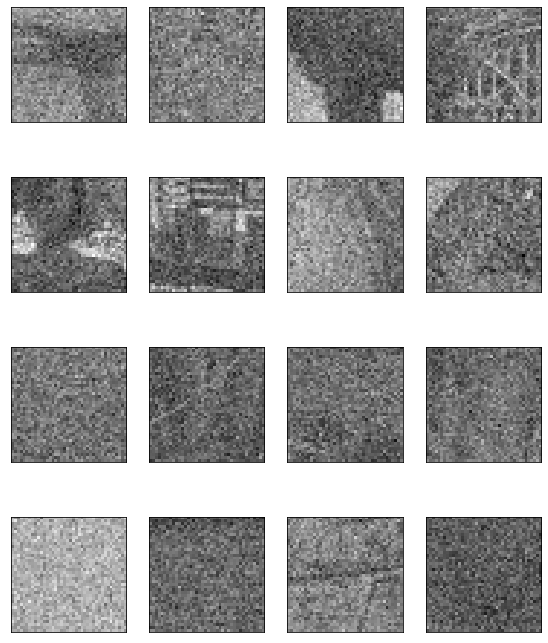



And the corresponding patches with a different realization of the noise:


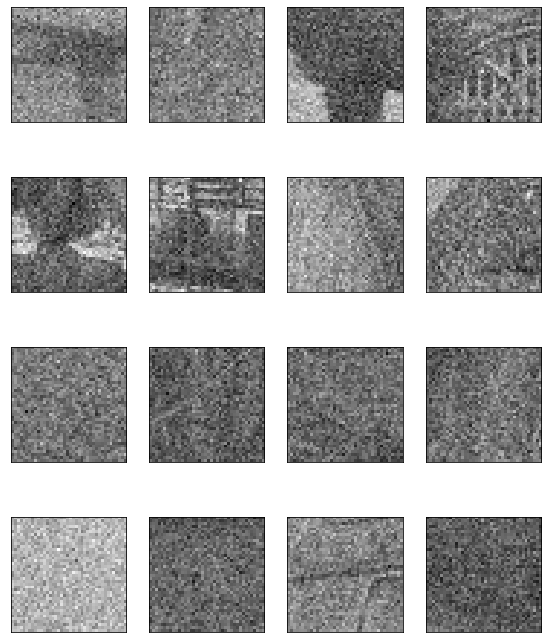

In [4]:
from denoising_dataloaders import train_val_denoising_dataloaders
import vistools

# noise level
p = 40

# create the data loader - note 'noise_type' argument
train_loader, val_loader = \
    train_val_denoising_dataloaders('./datasets/Train400/',
                                     noise_sigma=p,
                                     crop_size=40,
                                     train_batch_size=16,
                                     noise_type='gaussian',
                                     noise2noise=True)

# visualize first mini-batch
X, Y = list(train_loader)[0]

# this helper function displays the patches in the mini-batch
print('\n\nA minibatch of noisy patches:')
vistools.display_patches(X)

print('\n\nAnd the corresponding patches with a different realization of the noise:')
vistools.display_patches(Y)

This is the training code.

In [5]:
from models import DnCNN
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel

p=30

loss_name = 'l1'
#loss_name = 'l2'

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training: 
    # data
    train_loader, val_loader = train_val_denoising_dataloaders(
                                              './datasets/Train400/',
                                               noise_sigma=p, crop_size=40, 
                                               train_batch_size=128,
                                               noise_type='gaussian',
                                               noise2noise=True)

    # network model
    dncnn = DnCNN(in_channels=1, out_channels=1, 
                  num_layers=7, features=13, kernel_size=3, residual=True)

    # run the training loop
    loss = nn.L1Loss() if loss_name == 'l1' else nn.MSELoss()
    dncnn, losst, lossv = trainmodel(dncnn, loss, train_loader, val_loader, 
                                    num_epochs=2000, save_every=500, loss_every=100,  
                                    learning_rate=0.01, weight_decay=0.00001,
                                    filename='pre-trained-tp2/tiny_DnCNN_n2n_%s_' % loss_name)

    # plot loss
    plt.semilogy(lossv, label='val')
    plt.semilogy(losst, label='train')
    plt.legend()

### Gaussian noise denoisers trained with $L_1$ and $L_2$ losses and noisy targets

We have trained our tiny DnCNN network with the MSE (or squared L2 loss) and the L1 loss following the noise2noise approach. Let's compare the results.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


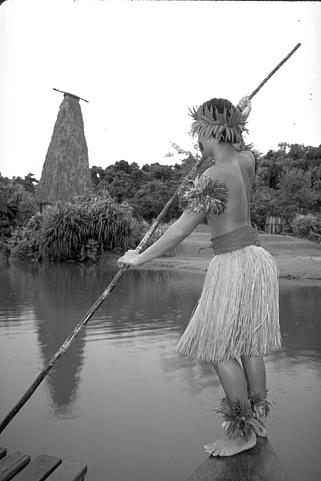
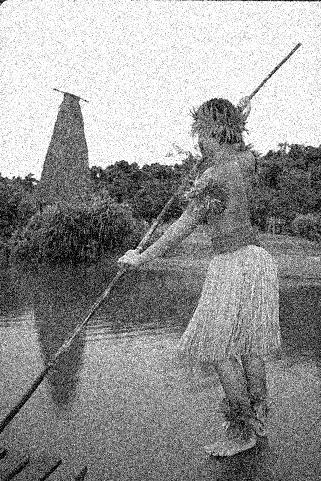
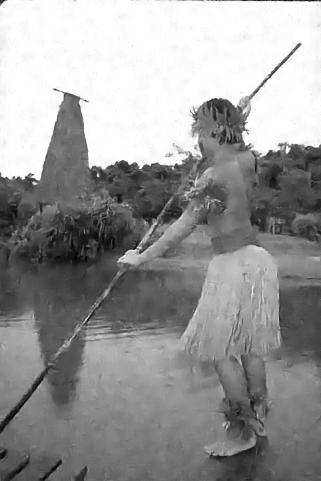
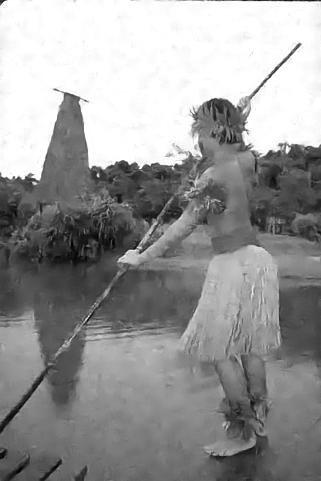
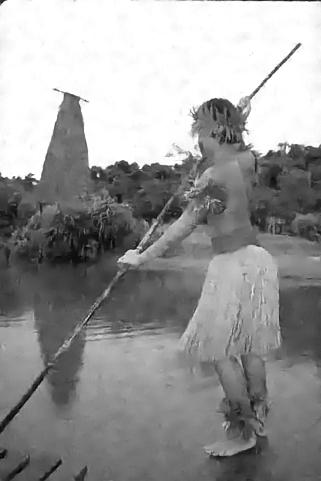

In [6]:
# denoise image with both models
from models import DnCNN
from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

sigma=30
im_clean = io.imread('datasets/BSD68/test002.png').astype(np.float32)
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

outputs = list()

outputs.append((im_clean, 'clean image'))
outputs.append((im_noisy, 'noisy input with sigma = %f' % (sigma)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_n2n_l2_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l2 loss, n2n training - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_n2n_l1_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l1 loss, n2n training - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l1 loss - PSNR = %f' % PSNR(out, im_clean)))

vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

### Uniform S&P noise denoisers trained with $L_1$ and $L_2$ losses and noisy targets

We have trained our tiny DnCNN network with the MSE (or squared L2 loss) and the L1 loss following the noise2noise approach. Let's compare the results.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


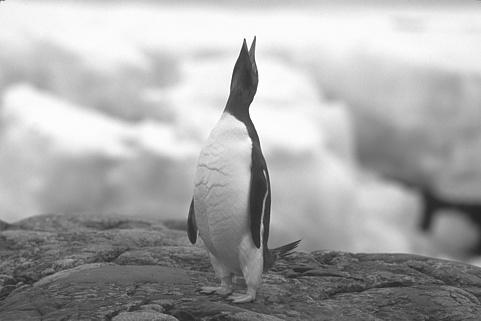
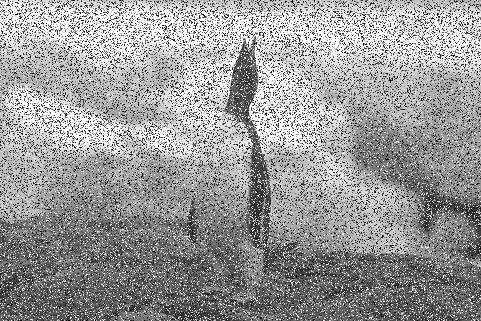
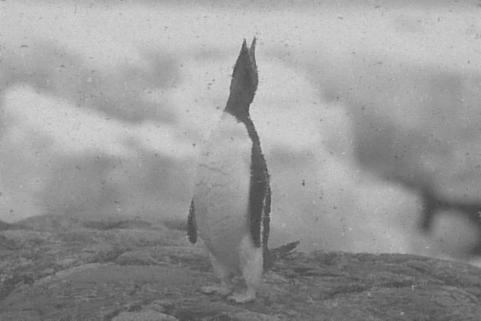
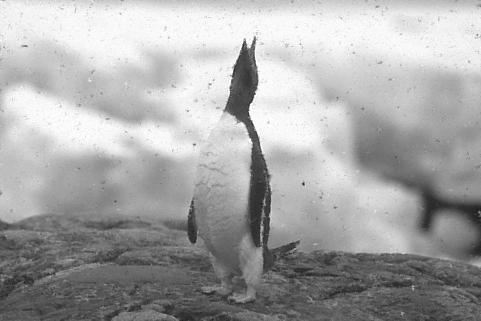
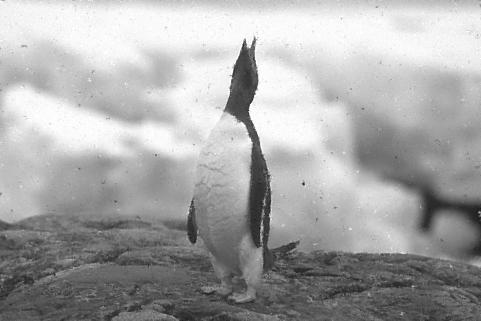

In [7]:
# denoise image with both models
from models import FFDNet, FFDNet_pretrained_grayscale
from models import DnCNN, DnCNN_pretrained
from skimage import io
from denoising_helpers import test_denoiser, PSNR

p=0.4
im_clean = io.imread('datasets/BSD68/test006.png').astype(np.float32)
mask = np.random.binomial(1, 1-p, im_clean.shape)
noise = 255. * np.random.uniform(0, 1, im_clean.shape)
im_noisy = im_clean * mask + noise * (1 - mask)


outputs = list()

outputs.append((im_clean, 'clean image'))
outputs.append((im_noisy, 'noisy input with sigma = %f' % (sigma)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_n2n_l2_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l2 loss, n2n training - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_n2n_l1_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l1 loss, n2n training - PSNR = %f' % PSNR(out, im_clean)))

net = torch.load('pre-trained-tp2/tiny_DnCNN_l1_usp_2000.pt' , map_location=loadmap)[0]
out = test_denoiser(net, im_noisy, None, has_noise=True)[0]
outputs.append((out, 'l1 loss - PSNR = %f' % PSNR(out, im_clean)))


vistools.display_gallery(unzip(outputs,0), unzip(outputs,1))

<font color='blue'>**Question 1.**
When training with noisy targets
1. Is there any notorious difference between the results obtained with both losses  with Gaussian noise ?
2. What about with the uniform S&P noise? 
3. Give an explanation for the observed behaviour.</font> 

<font color='red'>**ANSWER TO QUESTION 1**</font>

1. For the Gaussian noise, the results obtained with L1 and L2 losses are almost the same.

2. In the case of S&P noise, the image denoised with L2 norm looks much darker, wheareas the image denoised with L1 look really good.

3. The optimal estimator for the (squared) L2 loss is the mean, and for the L1 loss is the median. For a Gaussian its mean equals it median, that explains why we obtained the same results. However, for S&P the meadian is not equal to its mean, and that explains why the results are different and also that the the best results are obtained with L1 (we showed in the previous homework that the median of the noisy image is the the clean one).



---------------------------
[//]: # (© 2018 Gabriele Facciolo and Pablo Arias)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo and Pablo Arias. All rights reserved.</div> )

# Peeking inside the DnCNN network with layer inspectors

We will introduce layer inspectors to see the intermediate results for the hidden layers of a network. We define a layer inspector as the simplest affine transformation (convolutional) that takes a hidden layer and produces an output image. In DnCNN, each layer inspectors are $1\times 1$ convolutional layers that take the features at a given layer and produce a single image. These inspectors have to be trained. We will trained them *after* DnCNN was trained.

Below we define an inspector module `DnCNNInspector`, which receives a trained DnCNN network  $\mathcal F$ as input. For each layer of DnCNN we add an inpector layer, which we'll denote by $\mathcal I^l_{\theta}$. The inspector is applied to the output of layer $l$ of the denoising network $\mathcal F$. We will denote that output $\mathcal F^l(u)$, where $u$ is the input image.

Note that we only train the parameters of the inspectors. We prevent training the parameters of the input network, by setting their `require_grad` field to false with the following lines:


``` python
        # we don't want to train the dncnn parameters
        for p in self.dncnn.parameters():
            p.requires_grad = False
```

In [8]:
from models import DnCNN

class DnCNNInspector(nn.Module):
    def __init__(self, dncnn):
        """
        Args: 
            - dncnn: a dncnn network
        """
        super(DnCNNInspector, self).__init__()
            
        # retrieve parameters of dncnn network
        self.num_layers   = len(dncnn.layers)
        self.out_channels = dncnn.layers[-1].weight.shape[0]
        self.in_channels  = dncnn.layers[0].conv.weight.shape[1]
        self.residual     = dncnn.residual
        
        import copy
        self.dncnn = copy.deepcopy(dncnn)
        
        # we don't want to train the dncnn parameters
        for p in self.dncnn.parameters():
            p.requires_grad = False
        
        # define inspector layers
        self.inspectors = []
        for i in range(self.num_layers-1):
            self.inspectors.append(nn.Conv2d(dncnn.layers[i].conv.weight.shape[0],
                                             self.out_channels,
                                             1)) # <-- 1x1 kernel
            name = 'inspector%d' % i
            self.register_parameter(name + 'weight', self.inspectors[i].weight)
            self.register_parameter(name + 'bias'  , self.inspectors[i].bias)

   
    def forward(self, x):
        """
        """
        
        # force eval mode in dncnn network
        self.dncnn.eval()

        outputs = []
        out = x
        for i in range(self.num_layers-1):
            # apply layer of dncnn
            out = self.dncnn.layers[i](out)
            
            # apply inspector
            if self.residual:
                outputs.append(x - self.inspectors[i](out))
            else:
                outputs.append(self.inspectors[i](out))

        # returns a tensor having all the produced outputs as channels
        # the number of channels is (num_layers-1)*ch, where ch is the 
        # number of channels of x
        return torch.cat(outputs,-3)

To train the inspectors we need a custom loss (because the inspector network produces multiple output images). The following block defines our `multiOutputMSELoss`. Our loss will be the MSE between the images produced by each inspector and the clean image:
$$R^{\text{emp}}(\theta) = \frac 1{L-1}\sum_i \sum_{l=1}^{l = L-1} \|\mathcal I^l_\theta(\mathcal F^l(u)) - \widetilde u\|^2.$$
The parameters $\theta$ here are the weights and biases of each inspector.

In [9]:
# we define this loss, so that we can train all inspectors in parallel
def multiOutputMSELoss(x, y):
    """
    Computes the average MSE loss multiple outputs x_1, ...., x_n with respect
    to a single target y.
    
    Args:
        - x: outputs, 4D tensor of size [b, n*ch, w, h] where b is the batch size, n is
             the number of ouputs, ch is the number of channels of each output and wxh
             their spatial dimension
        - y: target, 4D tensor of size [b, ch, w, h]
    
    Returns:
        - loss: average MSE loss, i.e. 1/n * \sum_i MSELoss(x_i,y)
    """
    
    if x.shape[-3] % y.shape[-3] != 0:
        print('multiOutputMSELoss: x num. of channels is not a multiple of y num. of channels')
    n = x.shape[-3]//y.shape[-3]
    
    return ((x - torch.cat([y]*n,1))**2).mean()

We are now ready to train our inspectors. In the following blocks we train and apply the instector network to peack inside DnCNN by displaying the intermediate results thoughout the network for image.

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc

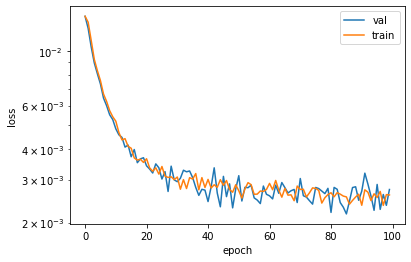

In [10]:
# train layer inspectors by minimizing the multi output MSE loss

from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN, DnCNN_pretrained

sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training:

    # data
    trainloader, validationloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=40, 
                                               train_batch_size=128)

    # load a dncnn network, and build an inspector for it
    #dncnn = torch.load('trainings/tiny_DnCNN_mse_2000.pt', map_location=loadmap))[0]
    dncnn = DnCNN_pretrained(sigma)
    dncnn_ins = DnCNNInspector(dncnn)

    # run the training loop
    dncnn_ins, losst, lossv, = trainmodel(dncnn_ins, multiOutputMSELoss, trainloader, validationloader, 
                                         num_epochs=100, save_every=100, loss_every=10,  
                                         learning_rate=0.01, weight_decay=0.00001,
                                         filename='pre-trained-tp3/layer_inspector_DnCNN_')

else:
    dncnn_ins, _, losst, lossv = torch.load('pre-trained-tp3/layer_inspector_DnCNN_0100.pt', map_location=loadmap)

# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');

downloading pretrained models


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.DnCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'models.DnCNN.CONV_BN_RELU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patc


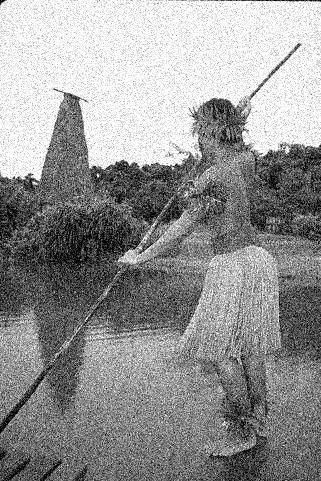
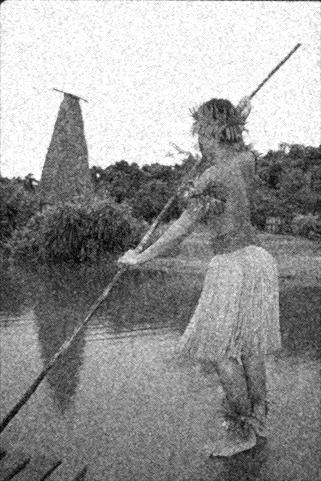
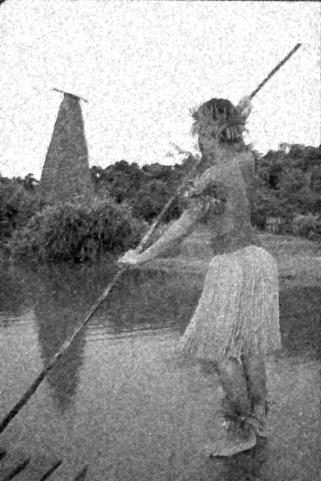
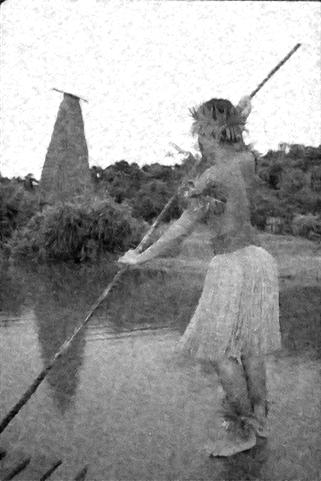
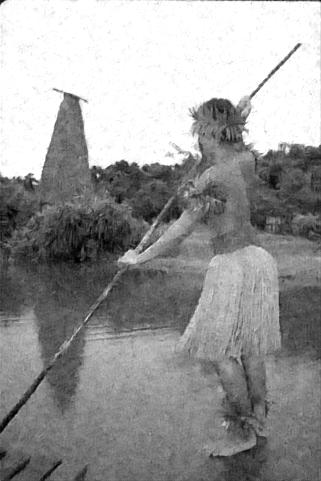
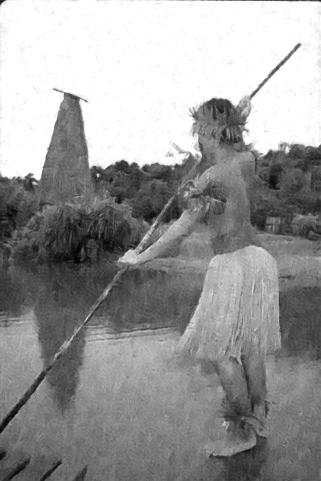
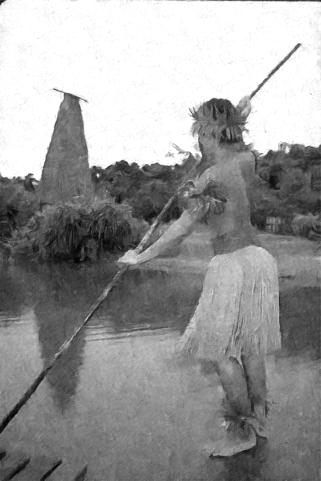
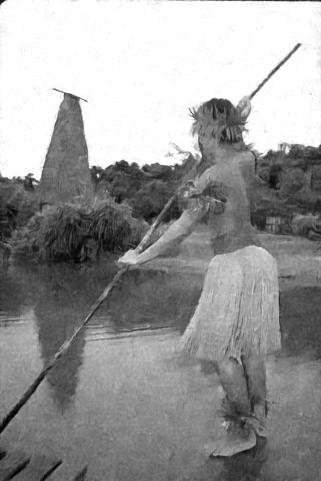
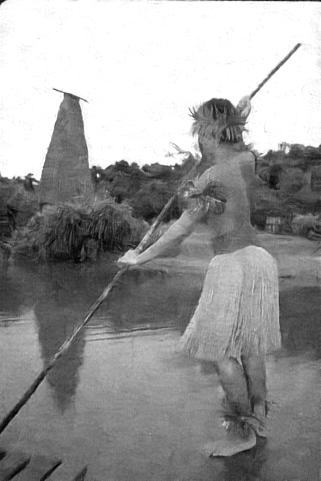
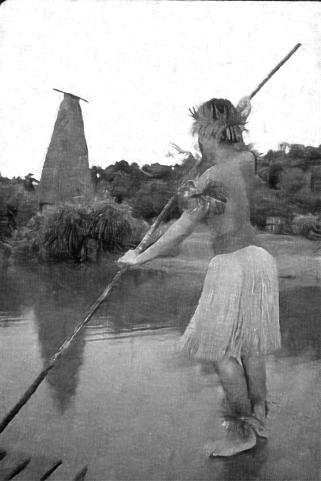
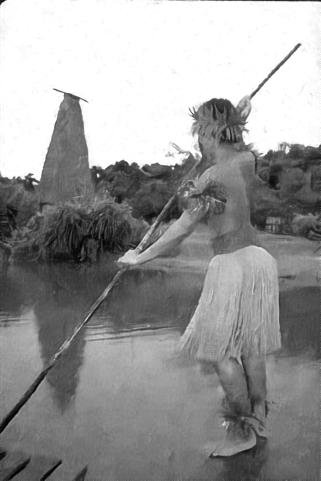
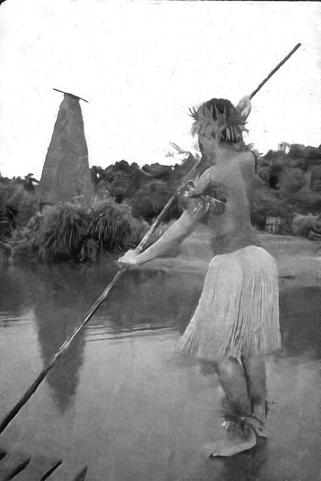
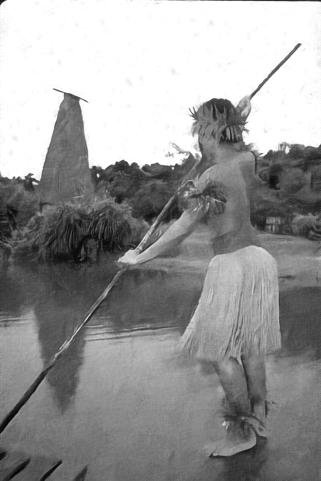
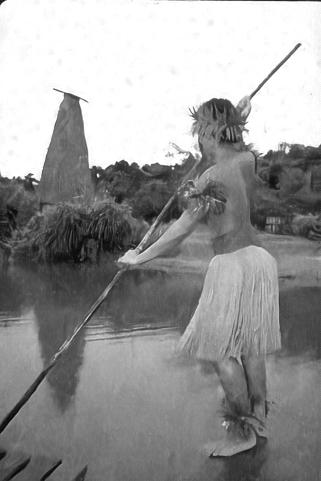
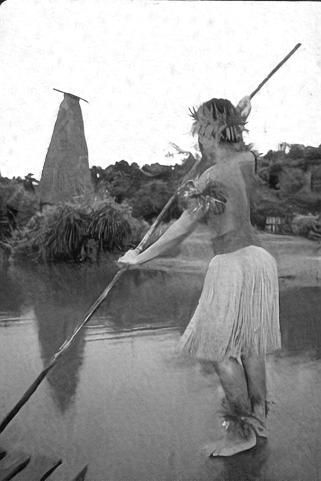
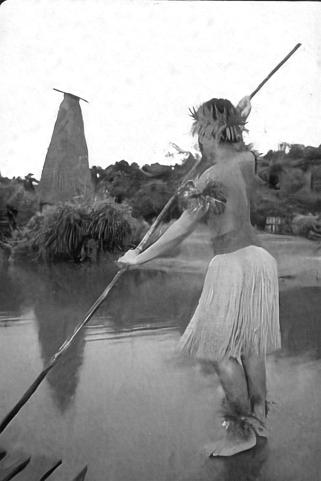
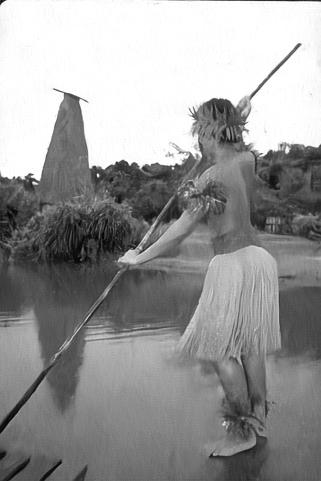
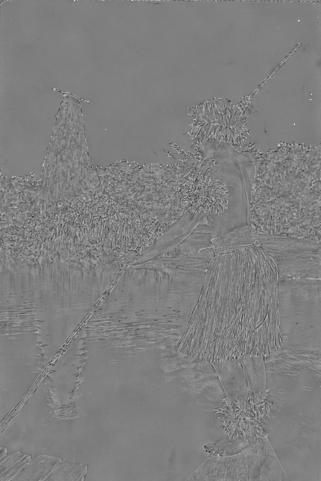

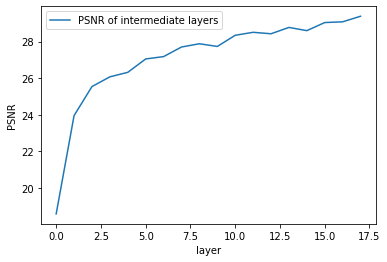

In [11]:
from skimage import io
from denoising_helpers import PSNR
from vistools import unzip

# test it with a noisy image
sigma=30
im_clean = io.imread('datasets/BSD68/test002.png').astype('float32') 
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

# put the image in the range [0,1] and add noise
im_noisy = im_noisy.astype('float32') / 255.

# create inpector from existing dncnn
dncnn = DnCNN_pretrained(sigma)
dncnn_ins = torch.load('pre-trained-tp3/layer_inspector_DnCNN_0100.pt', map_location=loadmap)[0]


# torch data type
dtype = torch.FloatTensor
if torch.cuda.is_available():
    # run on GPU
    dncnn_ins = dncnn_ins.cuda()
    dncnn = dncnn.cuda()
    dtype = torch.cuda.FloatTensor

# set denoising network in evaluation (inference) mode
dncnn_ins.eval()
dncnn.eval()

# apply inspector network
with torch.no_grad(): # tell pytorch that we don't need gradients
    img = dtype(im_noisy[np.newaxis,np.newaxis,:,:]) # convert to tensor
    out  = dncnn(img).cpu()
    outs = dncnn_ins(img).cpu()

out_ims = list()
out_psnrs = list()

# append noisy input to visualization list
out_psnr = PSNR(im_noisy*255, im_clean)
out_ims.append( (im_noisy*255, 'noisy - PSNR = %f' %(out_psnr)))
out_psnrs.append( out_psnr )


for i in range(outs.shape[1]):
    out_psnr = PSNR(outs[0,i,:,:]*255, im_clean)
    out_ims.append( ((outs[0,i,:,:].numpy())*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
#   out_ims.append( ((outs[0,i,:,:].numpy()-im_clean/255. + 0.5)*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
    out_psnrs.append(out_psnr)

out_psnr = PSNR(out*255, im_clean)
out_ims.append( (out.numpy()*255 - im_clean + 127.5, 'output - PSNR = %f' %(out_psnr)))
out_psnrs.append( out_psnr )
    
# show as a gallery
vistools.display_gallery(unzip(out_ims,0), unzip(out_ims,1))

# plot evolution of psnr
plt.plot(out_psnrs, label='PSNR of intermediate layers')
plt.legend(); plt.xlabel('layer'); plt.ylabel('PSNR');

<font color='blue'>**Question 2.**
Comment on the intermediate results on the network. Compare the outputs of the initial layers with the last ones.</font> 

<font color='red'>**ANSWER TO QUESTION 2.**</font>

From the images is clear that the denoising becomes better at each layer. The final layers produce far better results than the first ones. This is also observed in the PSNR plot, where we observe how the PSNR increases with the number of layers. In particular, the sky regions looks much more noisy in the first layers.

# Strangled DnCNN

We will now return to DnCNN (our default denoising network) to do an experiment. We will include, in our tiny DnCNN a "*strangling*" hidden layer with with one channel.

In [13]:
# definition of DnCNN module with added strangled layers.

class CONV_BN_RELU(nn.Module):
    '''
    PyTorch Module grouping together a 2D CONV, BatchNorm and ReLU layers.
    This will simplify the definition of the DnCNN network.
    '''

    def __init__(self, in_channels=128, out_channels=128, kernel_size=7, 
                 stride=1, padding=3):
        '''
        Constructor

        Args:
            - in_channels: number of input channels from precedding layer
            - out_channels: number of output channels
            - kernel_size: size of conv. kernel
            - stride: stride of convolutions
            - padding: number of zero padding

        Return: initialized module
        '''
        super(__class__, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride=stride, padding=padding)
        self.bn   = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        '''
        Applies the layer forward to input x
        '''
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        
        return(out)



class StrangledDnCNN(nn.Module):
    '''
    PyTorch module for the DnCNN network.
    '''

    def __init__(self, in_channels=1, out_channels=1, num_layers=17, 
                 features=64, kernel_size=3, residual=True,
                 strangling_layers = None):
        '''
        Constructor

        Args:
            - in_channels: input image channels (default 1)
            - out_channels: output image channels (default 1)
            - num_layers: number of non-strangling layers (default 17)
            - num_features: number of hidden features (default 64)
            - kernel_size: size of conv. kernel (default 3)
            - residual: use residual learning (default True)
            - strangling_layers: indices of the layers where strangling is added

        Return: initialized network
        '''
        super(__class__, self).__init__()
        
        if strangling_layers is None:
            strangling_layers = (num_layers-2)//2
        
        strangling_mask = np.zeros(num_layers)
        strangling_mask[strangling_layers] = 1
        print ('Strangled layers: ', strangling_mask )
        
        self.residual = residual
        
        # a list for the layers
        self.layers = []
        
        # first layer
        self.layers.append(CONV_BN_RELU(in_channels=in_channels,
                                        out_channels=features,
                                        kernel_size=kernel_size,
                                        stride=1, padding=kernel_size//2))
        # half of intermediate layers
        for l in range(num_layers-2):
            self.layers.append(CONV_BN_RELU(in_channels=features,
                                            out_channels=features,
                                            kernel_size=kernel_size,
                                            stride=1, padding=kernel_size//2))
            
            if strangling_mask[l+1]:
                # strangling layers
                self.layers.append(CONV_BN_RELU(in_channels=features,
                                                out_channels=in_channels,
                                                kernel_size=kernel_size,
                                                stride=1, padding=kernel_size//2))

                self.layers.append(CONV_BN_RELU(in_channels=in_channels,
                                                out_channels=features,
                                                kernel_size=kernel_size,
                                                stride=1, padding=kernel_size//2))

        # last layer 
        self.layers.append(nn.Conv2d(in_channels=features,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     stride=1, padding=kernel_size//2))
        # chain the layers
        self.dncnn = nn.Sequential(*self.layers)

        
    def forward(self, x):
        ''' Forward operation of the network on input x.'''
        out = self.dncnn(x)
        
        if self.residual: # residual learning
            out = x - out 
        
        return(out)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

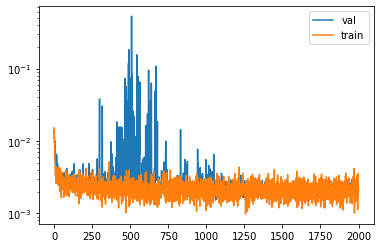

In [14]:
from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN
from torch import nn


sigma=30

# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training:
    # data
    trainloader, valloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=40, 
                                               train_batch_size=32 )

    # network model
    denoiser = StrangledDnCNN(in_channels=1, out_channels=1, 
                              num_layers=7,
                              features=13,
                              kernel_size=3, 
                              residual=True,
                              strangling_layers=[3]) # Strangled1
#                               strangling_layers=[2,4]) # Strangled2


    # loss
    loss = nn.MSELoss()

    # run the training loop
    denoiser, losst, lossv, = trainmodel(denoiser, loss, trainloader, valloader, 
                                        num_epochs=2000, save_every=1000, loss_every=200,  
                                        learning_rate=0.01, weight_decay=0.00001,
                                        filename='pre-trained-tp3/tiny_Strangled1_DnCNN_')

else:
    denoiser, _, losst, lossv = torch.load('pre-trained-tp3/tiny_Strangled1_DnCNN_2000.pt', map_location=loadmap)

# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.show()

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set


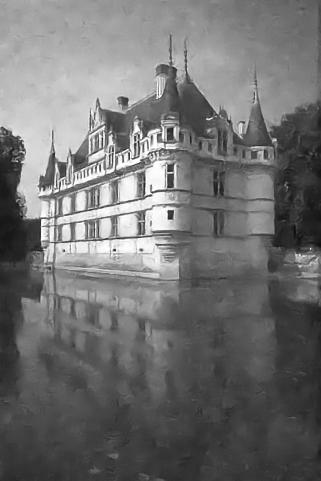
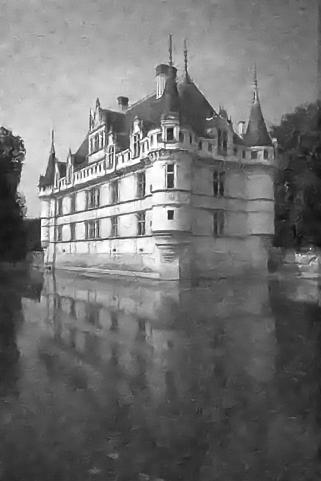
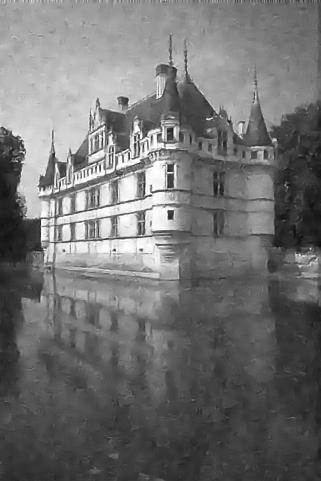
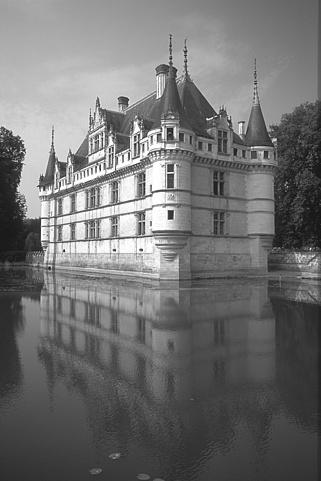
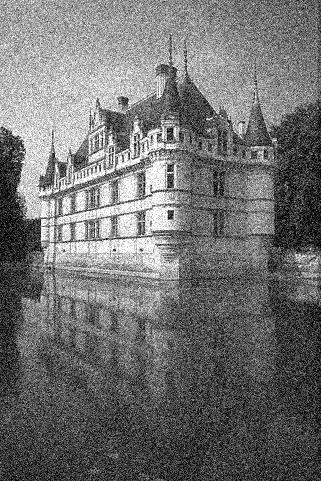

In [15]:
# Compare the denoising results

from skimage import io
from denoising_helpers import test_denoiser, PSNR
from vistools import unzip

# load denoising nets

# load an image
img_clean = io.imread('datasets/BSD68/test003.png').astype(np.float32)
img_noisy = img_clean + np.random.normal(0, sigma, img_clean.shape)

outs = list()

net = torch.load('pre-trained-tp2/tiny_DnCNN_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'tiny DnCNN - %f (dB)' % (PSNR(out, img_clean)) ) ) 

net = torch.load('pre-trained-tp3/tiny_Strangled1_DnCNN_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'tiny DnCNN 1 strangling layer - %f (dB)' % (PSNR(out, img_clean)) ) ) 

net = torch.load('pre-trained-tp3/tiny_Strangled2_DnCNN_2000.pt', map_location=loadmap)[0]
out = test_denoiser(net, img_noisy, sigma, has_noise=True)[0]
outs.append( (out, 'tiny DnCNN 2 stragling layers - %f (dB)' % (PSNR(out, img_clean)) ) ) 

outs.append( (np.array(img_clean).clip(0,255), 'clean'))
outs.append( (np.array(img_noisy).clip(0,255), 'noisy'))

vistools.display_gallery(unzip(outs,0), unzip(outs,1))

<font color='blue'>**Question 3.**
1. What is the effect of the strangling layers on the networks performance? 
2. What would you expect about the performance of the *trainable inference* networks that we saw in the theory, compared to black-box networks like DnCNN (i.e. networks where the architecture is not derived from an iterative optimization algorithm).</font> 

<font color='red'>**ANSWER TO QUESTION 3.**</font>

1. The stranling layers seems to produce images with more high-frequency content which may be harmful for the performance in flat areas (like the sky). For one strangling layer the results are almost identical, but there are some small differences (especially visible in the sky). In addition, in the case of two strangling layers there visible artifacts on the top of the image. 

2. I expect the black-box model to perform better since the trainable inference networks have a strangling constraint devired from the iterative optimization.

# Layer inspectors for the strangled DnCNN network

We will use our layer inspectors to evaluate the effect of the strangling layers in our StrangedDnCNNs. We need to train our inspector module `DnCNNInspector`, for the StrangledDnCNN networks.

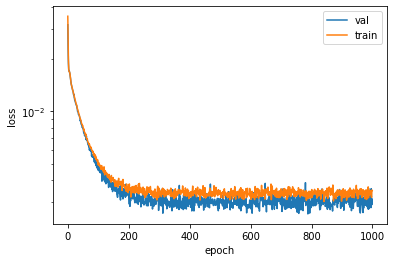

In [16]:
# train layer inspectors by minimizing the multi-output MSE loss

from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN, DnCNN_pretrained

sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training:

    # data
    trainloader, validationloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=40, 
                                               train_batch_size=128)

    # load a dncnn network, and build an inspector for it
    dncnn = torch.load('pre-trained-tp3/tiny_Strangled1_DnCNN_2000.pt', map_location=loadmap)[0]
    dncnn_ins = DnCNNInspector(dncnn)

    # run the training loop
    dncnn_ins, losst, lossv, = trainmodel(dncnn_ins, multiOutputMSELoss, trainloader, validationloader, 
                                         num_epochs=1000, save_every=500, loss_every=100,  
                                         learning_rate=0.01, weight_decay=0.00001,
                                         filename='trainings/layer_inspector_tiny_Strangled1_DnCNN_')

else:
    dncnn_ins, losst, lossv = torch.load('pre-trained-tp3/layer_inspector_tiny_Strangled1_DnCNN_1000.pt', map_location=loadmap)

# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');

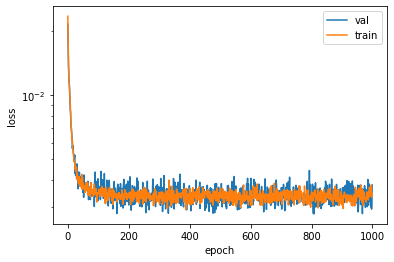

In [17]:
# train layer inspectors by minimizing the multi output MSE loss

from denoising_dataloaders import train_val_denoising_dataloaders
from training import trainmodel
from models import DnCNN, DnCNN_pretrained

sigma=30


# DO NOT set this flag to true if running on the server.
# The results are already pre-computed.
training=False

if training:

    # data
    trainloader, validationloader = train_val_denoising_dataloaders(
                                              './datasets/Train400/', 
                                               noise_sigma=sigma, crop_size=40, 
                                               train_batch_size=128)

    # load a dncnn network, and build an inspector for it
    dncnn = torch.load('pre-trained-tp2/tiny_DnCNN_2000.pt', map_location=loadmap)[0]
    dncnn_ins = DnCNNInspector(dncnn)

    # run the training loop
    dncnn_ins, losst, lossv, = trainmodel(dncnn_ins, multiOutputMSELoss, trainloader, validationloader, 
                                         num_epochs=1000, save_every=500, loss_every=100,  
                                         learning_rate=0.01, weight_decay=0.00001,
                                         filename='trainings/layer_inspector_tiny_DnCNN_')

else:
    dncnn_ins, losst, lossv = torch.load('pre-trained-tp3/layer_inspector_tiny_DnCNN_1000.pt', map_location=loadmap)


# plot loss
plt.semilogy(lossv, label='val')
plt.semilogy(losst, label='train')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set


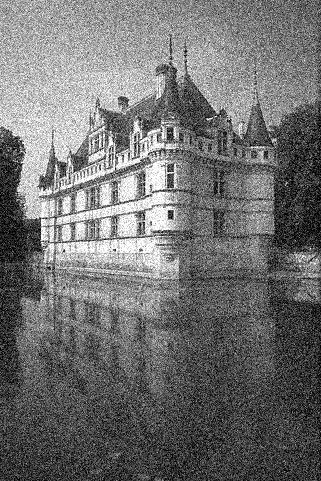
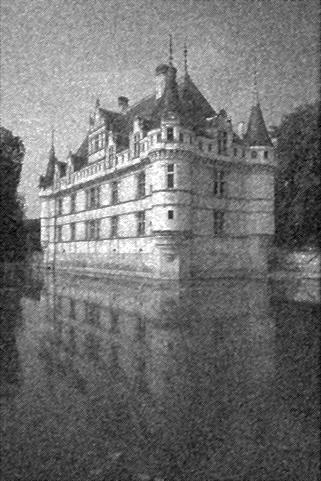
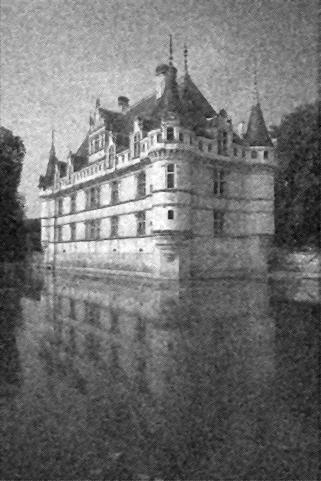
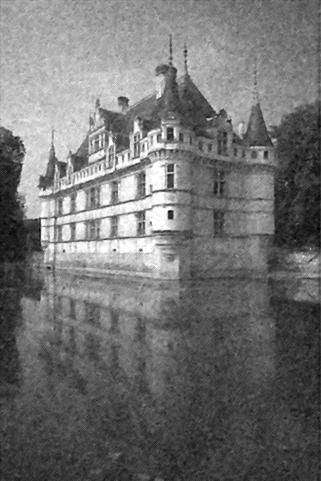
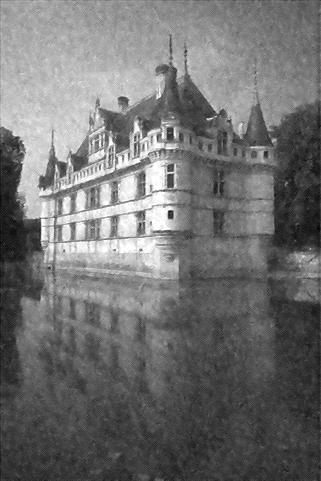
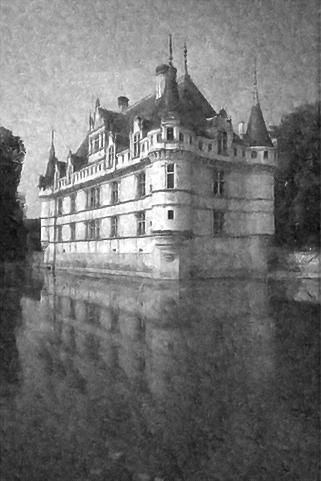
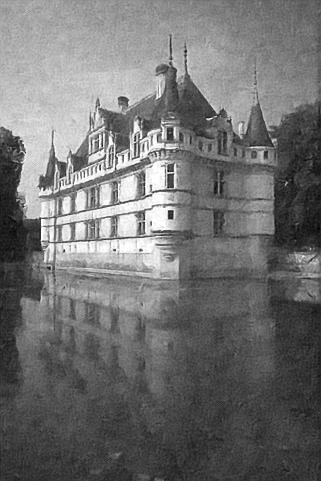
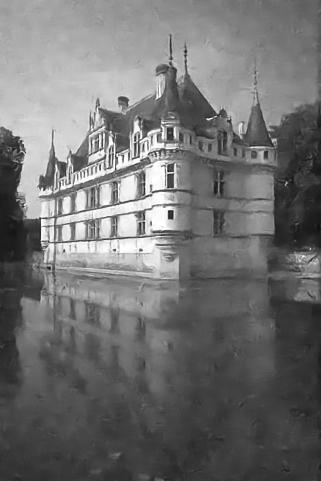


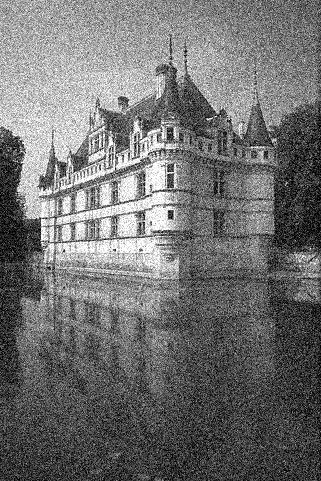
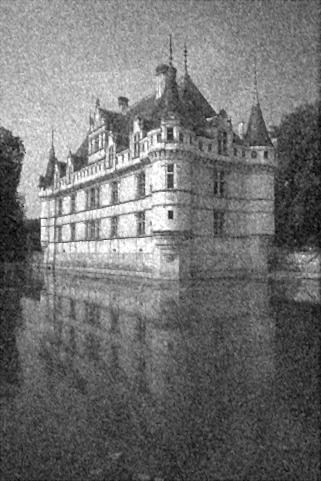
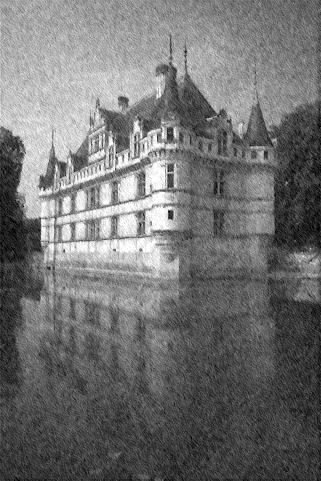
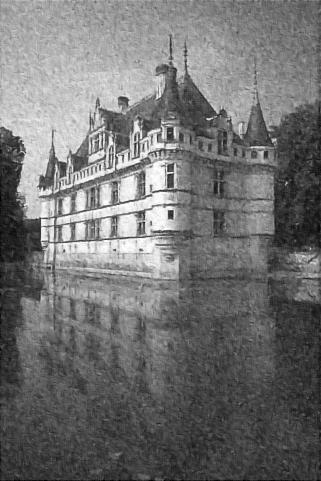
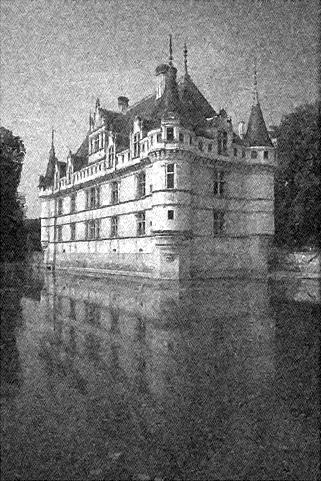
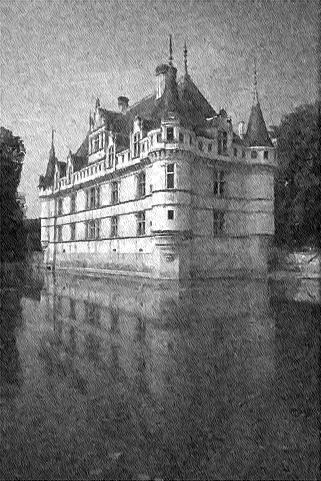
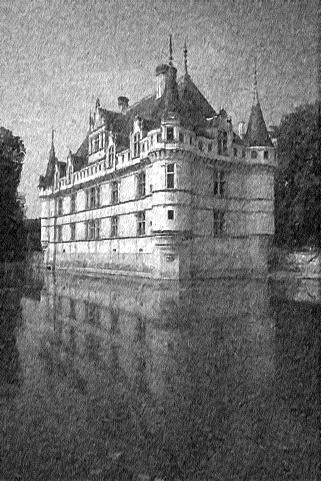
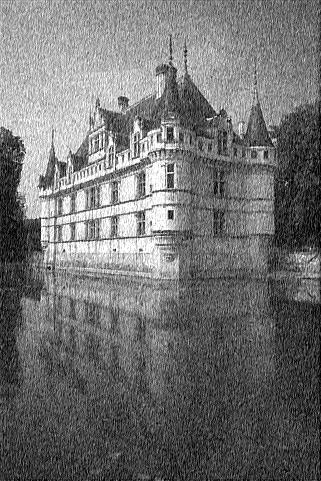
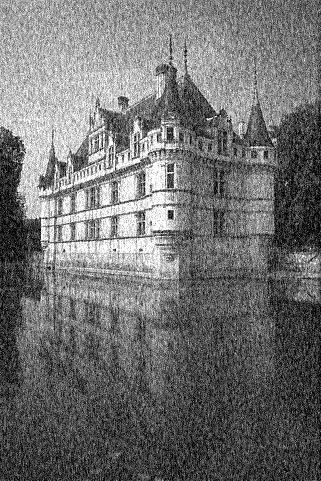
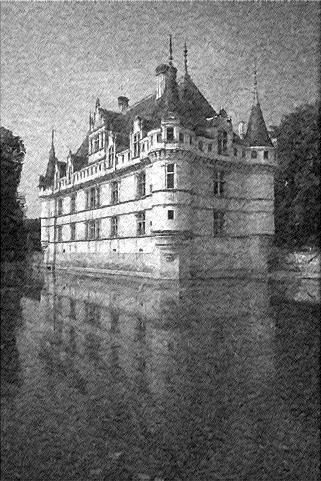
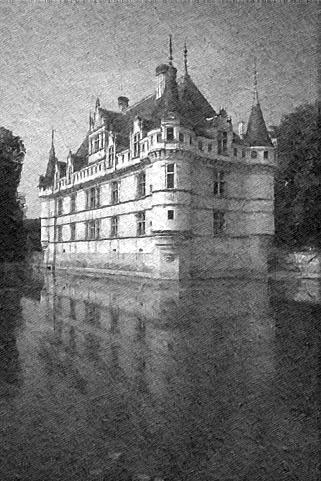
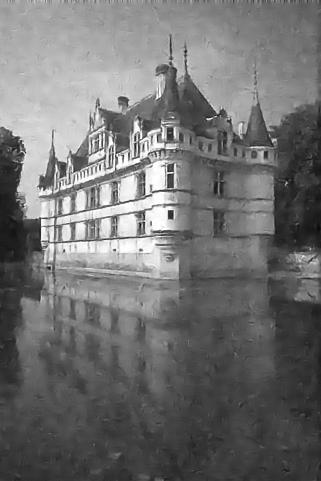

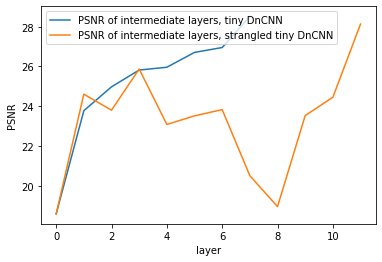

In [18]:
from skimage import io
from denoising_helpers import PSNR
from vistools import unzip

# test it with a noisy image
sigma=30
im_clean = io.imread('datasets/BSD68/test003.png').astype('float32') 
im_noisy = im_clean + np.random.normal(0, sigma, im_clean.shape)

# put the image in the range [0,1] and add noise
im_noisy = im_noisy.astype('float32') / 255.

# load tiny DnCNN and with and without strangling layers
dncnn           = torch.load('pre-trained-tp2/tiny_DnCNN_2000.pt'           , map_location=loadmap)[0]
#dncnn_strangled = torch.load('pre-trained-tp3/tiny_Strangled1_DnCNN_2000.pt', map_location=loadmap)[0]
dncnn_strangled = torch.load('pre-trained-tp3/tiny_Strangled2_DnCNN_2000.pt', map_location=loadmap)[0]

# load the corresponding layer inspectors
dncnn_ins           = torch.load('pre-trained-tp3/layer_inspector_tiny_DnCNN_1000.pt'           , map_location=loadmap)[0]
#dncnn_strangled_ins = torch.load('pre-trained-tp3/layer_inspector_tiny_Strangled1_DnCNN_1000.pt', map_location=loadmap)[0]
dncnn_strangled_ins = torch.load('pre-trained-tp3/layer_inspector_tiny_Strangled2_DnCNN_1000.pt', map_location=loadmap)[0]


# torch data type
dtype = torch.FloatTensor
if torch.cuda.is_available():
    # run on GPU
    dncnn = dncnn.cuda()
    dncnn_ins = dncnn_ins.cuda()
    dncnn_strangled = dncnn_strangled.cuda()
    dncnn_strangled_ins = dncnn_strangled_ins.cuda()
    dtype = torch.cuda.FloatTensor

# set denoising network in evaluation (inference) mode
dncnn_strangled_ins.eval()
dncnn_strangled.eval()
dncnn_ins.eval()
dncnn.eval()

# apply inspector network
with torch.no_grad(): # tell pytorch that we don't need gradients
    img = dtype(im_noisy[np.newaxis,np.newaxis,:,:]) # convert to tensor
    out_dncnn     = dncnn(img).cpu()
    out_dncnn_ins = dncnn_ins(img).cpu()
    out_dncnn_strangled     = dncnn_strangled(img).cpu()
    out_dncnn_strangled_ins = dncnn_strangled_ins(img).cpu()



# outputs for the tiny DnCNN ###################################
out_ims = list()
dncnn_ins_psnr = list()

# append noisy input to visualization list
out_psnr = PSNR(im_noisy*255, im_clean)
out_ims.append( (im_noisy*255, 'noisy - PSNR = %f' %(out_psnr)))
dncnn_ins_psnr.append( out_psnr )

for i in range(out_dncnn_ins.shape[1]):
    out_psnr = PSNR(out_dncnn_ins[0,i,:,:]*255, im_clean)
    out_ims.append( ((out_dncnn_ins[0,i,:,:].numpy())*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
#   out_ims.append( ((out_dncnn_ins[0,i,:,:].numpy()-im_clean/255. + 0.5)*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
    dncnn_ins_psnr.append(out_psnr)

out_psnr = PSNR(out_dncnn*255, im_clean)
#out_ims.append( (out_dncnn.numpy()*255 - im_clean + 127.5, 'output - PSNR = %f' %(out_psnr)))
out_ims.append( (out_dncnn.numpy()*255, 'output - PSNR = %f' %(out_psnr)))
dncnn_ins_psnr.append( out_psnr )
    
# show as a gallery
vistools.display_gallery(unzip(out_ims,0), unzip(out_ims,1))



# outputs for the tiny strangled DnCNN #########################
out_ims = list()
dncnn_strangled_ins_psnr = list()

# append noisy input to visualization list
out_psnr = PSNR(im_noisy*255, im_clean)
out_ims.append( (im_noisy*255, 'noisy - PSNR = %f' %(out_psnr)))
dncnn_strangled_ins_psnr.append( out_psnr )

for i in range(out_dncnn_strangled_ins.shape[1]):
    out_psnr = PSNR(out_dncnn_strangled_ins[0,i,:,:]*255, im_clean)
    out_ims.append( ((out_dncnn_strangled_ins[0,i,:,:].numpy())*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
#   out_ims.append( ((out_dncnn_strangled_ins[0,i,:,:].numpy()-im_clean/255. + 0.5)*255, 'inspector %d - PSNR = %f' %(i, out_psnr)) )    
    dncnn_strangled_ins_psnr.append(out_psnr)

out_psnr = PSNR(out_dncnn_strangled*255, im_clean)
#out_ims.append( (out_dncnn_strangled.numpy()*255 - im_clean + 127.5, 'output - PSNR = %f' %(out_psnr)))
out_ims.append( (out_dncnn_strangled.numpy()*255, 'output - PSNR = %f' %(out_psnr)))
dncnn_strangled_ins_psnr.append( out_psnr )
    
# show as a gallery
vistools.display_gallery(unzip(out_ims,0), unzip(out_ims,1))




# plot evolution of psnr
plt.plot(dncnn_ins_psnr, label='PSNR of intermediate layers, tiny DnCNN')
plt.plot(dncnn_strangled_ins_psnr, label='PSNR of intermediate layers, strangled tiny DnCNN')
plt.legend(); plt.xlabel('layer'); plt.ylabel('PSNR');

<font color='blue'>**Question 4.** The evolution of the PSNR through the layers of the strangling network is rather surprising. For the network with two strangling points the PSNR drops to the level of the noisy input at the last strangling point. Yet, the final output of the network is only a little bit worse (~0.4 dB) than the non-strangled one. Can you think of an explanation for this behaviour? If so, propose experiments to test your explanations. (This is an open question, for which we do not know the answer.)</font> 

<font color='red'>**ANSWER TO QUESTION 4.**</font>

The first strangling is near the first layers where the denoising is still no good, so the dropping on PSNR is not big since not much progress has been made. However, since the sencond strangling is near the end, the denoising at that point should be fairy good, and it makes sense that a strangling point there produces a significant drop in performance. Why the final output is only a bit worse that the non-strangled one? Maybe the part of the network that is actually doing the denoising are the layers after the second strangling.

One possible experiment I can think of to test this is to freeze the layers previous to the second strangling and train the denoising only for the final layers. If we get good denoising results, indeed what happens before the sencond strangling does not matter and we would have proved that the only parts of the network that are actually doing denoising are the final layers after the strangling.